In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import gaussian_kde
from WUMBO import Wumbo


#Make 3D Dataset
centers = [[0,0,0], [-1, -1,0], [1, -1,0], [0,0.5,2.2], [0.4,0.1,2.1], [3.5,4,0.25], [5,1,0.1], [1.5,2,1], [2,2,0], [7,6,0.5]]
X, labels_true = make_blobs(n_samples=500, centers=centers, cluster_std=0.6,
                            random_state=42)
#X = np.vstack([X,[0,2.8]])

#Make UID's 
dfblobs = pd.DataFrame(X, columns=["v1","v2","v3"])
dfblobs = dfblobs.reset_index(drop=True)
dfblobs["uid"] = dfblobs.index
print(dfblobs)

           v1        v2        v3  uid
0    1.462444  1.547621  0.831595    0
1    5.125030 -0.225041 -0.048306    1
2    1.321462  2.825424  0.909967    2
3    5.425402  0.946159  0.964070    3
4    0.055803 -0.228115  2.080348    4
..        ...       ...       ...  ...
495  5.149630  1.946472  0.042823  495
496  1.578805  1.602259 -0.841563  496
497 -0.127880 -1.158794  1.632101  497
498  1.245240  1.022675  2.004386  498
499  0.986981  0.350578  2.545934  499

[500 rows x 4 columns]


In [3]:
# Create and Run WUMBO Model on a 3-Dimensional dataset

# Showing top 5% of Outliers, Filtering Duplicate UID's is on

est = Wumbo(dataframe=dfblobs, uidColumnName="uid", filterValue=True, alpha=0.01)
wumbo_df = est.apply()

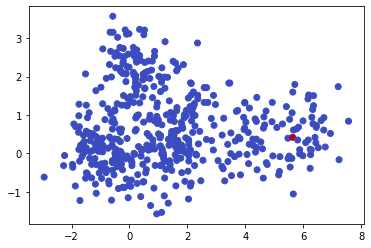

In [5]:
plt.scatter(x=wumbo_df['v2'], y=wumbo_df['v3'], c=wumbo_df["Risk Score"], cmap="coolwarm")

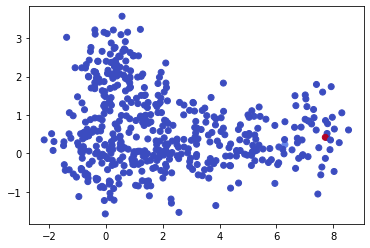

In [6]:
plt.scatter(x=wumbo_df['v1'], y=wumbo_df['v3'], c=wumbo_df["Risk Score"], cmap="coolwarm")


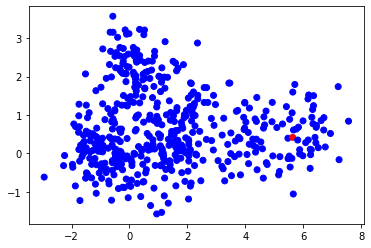

In [7]:
plt.scatter(x=wumbo_df['v2'], y=wumbo_df['v3'], c=wumbo_df["Risk Score"], cmap="bwr")


In [8]:
wumbo_df_outliers = wumbo_df.loc[wumbo_df["Outlier"]==1]

print("Total Rows in Dataset: " + str(len(wumbo_df)))
print("Total Outliers: " + str(len(wumbo_df_outliers)))
print("Total Percent Outliers: " + str(round(100*len(wumbo_df_outliers)/len(wumbo_df))) + "%")

Total Rows in Dataset: 500
Total Outliers: 21
Total Percent Outliers: 4%


In [73]:
# Create 2-Dimensional Dataset

centers_2d = [[0,0], [-1,0], [0,0], [0.5,1], [0.5,0], [1, -1], [1.5,2], [2,2], [3,4], [5,4], [6,4], [11,5.5]]
X, labels_true = make_blobs(n_samples=500, centers=centers_2d, cluster_std=1.8,
                            random_state=42)


#Make UID's 
dfblobs_2d = pd.DataFrame(X, columns=["v1","v2"])
dfblobs_2d = dfblobs_2d.reset_index(drop=True)
dfblobs_2d["uid"] = dfblobs_2d.index
print(dfblobs_2d)


           v1        v2  uid
0    2.059099  5.888217    0
1    3.691153  3.554466    1
2   -0.163831 -2.946786    2
3   -1.083072  3.334101    3
4   -0.048744  1.307800    4
..        ...       ...  ...
495  7.094214  4.335896  495
496  2.345498  3.897498  496
497 -1.201696  4.692880  497
498  8.556908  2.972657  498
499  1.899268  1.468010  499

[500 rows x 3 columns]


In [74]:
# Create and Run WUMBO Model on the 2-Dimensional dataset

est2 = Wumbo(dataframe=dfblobs_2d, uidColumnName="uid", filterValue=False, alpha=0.01)
wumbo_df_2d = est2.apply()

In [75]:
# Describe Results

wumbo_df_outliers = wumbo_df_2d.loc[wumbo_df_2d["Outlier"] == 1]

print("Total Rows in Dataset: " + str(len(wumbo_df)))
print("Total Outliers: " + str(len(wumbo_df_outliers)))
print("Total Percent Outliers: " + str(round(100*len(wumbo_df_outliers)/len(wumbo_df))) + "%")

Total Rows in Dataset: 500
Total Outliers: 16
Total Percent Outliers: 3%


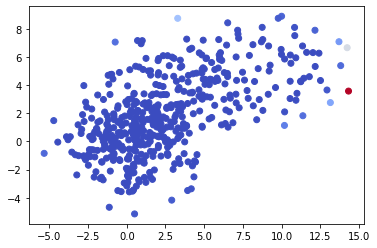

In [81]:
# Visualize Risk Scores

plt.scatter(x=wumbo_df_2d['v1'], y=wumbo_df_2d['v2'], c=wumbo_df_2d["Risk Score"], cmap="coolwarm")

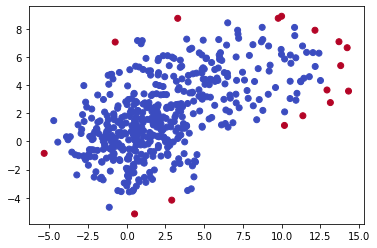

In [77]:
# Chart all outliers

wumbo_2d_outliers = wumbo_df_2d.loc[wumbo_df_2d["Outlier"]==1]
plt.scatter(x=wumbo_df_2d['v1'], y=wumbo_df_2d['v2'], c=wumbo_df_2d["Outlier"], cmap="coolwarm")